# Transformer Application

## Configuration

### Hyperparameters

In [1]:
from CustomLoss import CustomEmbeddingSliceLoss
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import MSELoss

import os

# HYPERPARAMETERS
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#transformer
NUM_HEADS = 6 # Dividers of 282: {1, 2, 3, 6, 47, 94, 141, 282}
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 8
DROPOUT=0.1

# Methods
loss_function = CustomEmbeddingSliceLoss()

os.getcwd()

'c:\\Users\\okan2\\Desktop\\team project\\Animate_SVG_v2'

### Constants

In [2]:
# CONSTANTS
FEATURE_DIM = 282

## Load Prepared Tensors from Disk
Run file `prototype_dataset.ipynb` first

In [3]:
import torch

train_sequence_input = torch.load('data/prototype_dataset/train_sequence_input.pt')
train_sequence_output = torch.load('data/prototype_dataset/train_sequence_output.pt')
test_sequence_input = torch.load('data/prototype_dataset/test_sequence_input.pt')
test_sequence_output = torch.load('data/prototype_dataset/test_sequence_output.pt')

In [4]:
from dataset_helper import warn_if_contains_NaN

warn_if_contains_NaN(train_sequence_input)
warn_if_contains_NaN(train_sequence_output)
warn_if_contains_NaN(test_sequence_input)
warn_if_contains_NaN(test_sequence_output)

In [5]:
print(train_sequence_input.size())
print(train_sequence_output.size())
print(test_sequence_input.size())
print(test_sequence_output.size())

torch.Size([1391, 95, 282])
torch.Size([1391, 95, 282])
torch.Size([187, 95, 282])
torch.Size([187, 95, 282])


## Build Dataloader with Batches

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_dataloader = DataLoader(TensorDataset(train_sequence_input.float(), train_sequence_output.float()),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
val_dataloader = DataLoader(TensorDataset(test_sequence_input.float(), test_sequence_output.float()),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True)

In [7]:
len(train_dataloader)

43

## Initialize

In [8]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)
torch.__version__

'2.1.1'

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [10]:
from torch import nn
from AnimationTransformer import AnimationTransformer

model = AnimationTransformer(
    dim_model=FEATURE_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT,
    use_positional_encoder=True
).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_param = sum(p.numel() for p in model.parameters())
print(f"The model has {total_param} trainable parameters")

The model has 17336972 trainable parameters


## Training

In [11]:
from AnimationTransformer import fit

train_loss_list, validation_loss_list = fit(model,
                                            optimizer,
                                            loss_function,
                                            train_dataloader,
                                            val_dataloader,
                                            epochs=20,
                                            device=device)

Training and validating model
------------------------- Epoch 1 -------------------------


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


>> 1: Time per Batch  1.70s | Total expected  1.22 min | Remaining  1.19 min 
>> 10: Time per Batch  0.97s | Total expected  0.70 min | Remaining  0.53 min 
>> 20: Time per Batch  0.93s | Total expected  0.67 min | Remaining  0.36 min 
>> 30: Time per Batch  0.91s | Total expected  0.65 min | Remaining  0.20 min 
>> 40: Time per Batch  0.91s | Total expected  0.65 min | Remaining  0.05 min 
>> Epoch time: 0.65 min


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\modules\transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training loss: 22.0429
Validation loss: 19.7590

------------------------- Epoch 2 -------------------------
>> 1: Time per Batch  1.16s | Total expected  0.83 min | Remaining  0.81 min 
>> 10: Time per Batch  0.91s | Total expected  0.65 min | Remaining  0.50 min 
>> 20: Time per Batch  0.90s | Total expected  0.65 min | Remaining  0.35 min 
>> 30: Time per Batch  0.90s | Total expected  0.65 min | Remaining  0.20 min 
>> 40: Time per Batch  0.89s | Total expected  0.64 min | Remaining  0.04 min 
>> Epoch time: 0.64 min
Training loss: 21.2219
Validation loss: 19.2304

------------------------- Epoch 3 -------------------------
>> 1: Time per Batch  0.98s | Total expected  0.70 min | Remaining  0.68 min 
>> 10: Time per Batch  0.90s | Total expected  0.64 min | Remaining  0.49 min 
>> 20: Time per Batch  0.89s | Total expected  0.64 min | Remaining  0.34 min 
>> 30: Time per Batch  0.89s | Total expected  0.64 min | Remaining  0.19 min 
>> 40: Time per Batch  0.89s | Total expected  0.

In [17]:
# Define the number of additional epochs you want to train for
additional_epochs = 19

# Continue training the model for more epochs
new_train_loss, new_validation_loss = fit(model,
                                          optimizer,
                                          loss_function,
                                          train_dataloader,
                                          val_dataloader,
                                          epochs=additional_epochs,
                                          device=device)

# Extend the original loss lists with the new loss values
train_loss_list.extend(new_train_loss)
validation_loss_list.extend(new_validation_loss)

Training and validating model
------------------------- Epoch 1 -------------------------
>> 1: Time per Batch  1.01s | Total expected  0.72 min | Remaining  0.70 min 
>> 10: Time per Batch  0.92s | Total expected  0.66 min | Remaining  0.51 min 
>> 20: Time per Batch  0.91s | Total expected  0.65 min | Remaining  0.35 min 
>> 30: Time per Batch  0.91s | Total expected  0.65 min | Remaining  0.20 min 
>> 40: Time per Batch  0.90s | Total expected  0.65 min | Remaining  0.05 min 
>> Epoch time: 0.65 min
Training loss: 14.2209
Validation loss: 13.3204

------------------------- Epoch 2 -------------------------
>> 1: Time per Batch  0.98s | Total expected  0.70 min | Remaining  0.69 min 
>> 10: Time per Batch  0.90s | Total expected  0.65 min | Remaining  0.50 min 
>> 20: Time per Batch  0.90s | Total expected  0.64 min | Remaining  0.34 min 
>> 30: Time per Batch  0.89s | Total expected  0.64 min | Remaining  0.19 min 
>> 40: Time per Batch  0.89s | Total expected  0.64 min | Remaining 

In [18]:
print("Train\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))

Train
 22,0429; 21,2219; 20,5376; 20,2414; 19,4597; 19,2919; 18,8497; 18,4159; 17,9759; 17,4912; 17,1714; 16,7800; 16,4508; 16,1255; 15,8795; 15,6191; 15,3108; 15,1890; 14,8123; 14,6978; 14,4360; 14,2209; 14,1379; 13,9073; 13,6951; 13,5789; 13,3429; 13,3020; 13,1226; 13,0193; 12,9384; 12,8434; 12,7725; 12,5813; 12,5073; 12,4239; 12,3976; 12,3716; 12,2347; 12,2418


In [19]:
print("Validation\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))

Validation
 19,7590; 19,2304; 18,7496; 18,2885; 17,8323; 17,4363; 17,0374; 16,6494; 16,3367; 15,9999; 15,6419; 15,3863; 15,1333; 14,8444; 14,5734; 14,3753; 14,1681; 13,9522; 13,7590; 13,6065; 13,4570; 13,3204; 13,1923; 13,0222; 12,9267; 12,8100; 12,7118; 12,6172; 12,5810; 12,4788; 12,4259; 12,3440; 12,3024; 12,2637; 12,2143; 12,1436; 12,1795; 12,1251; 12,1094; 12,0621


## Training and Validation Loss Plot

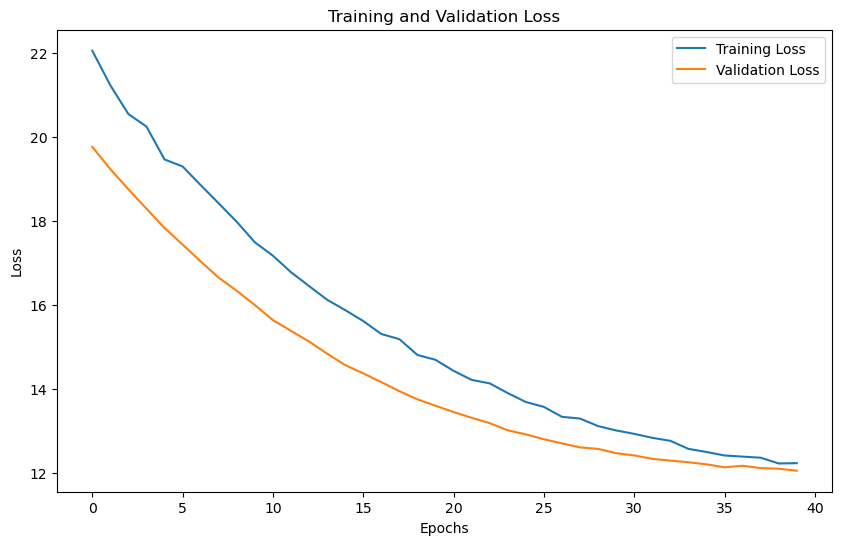

In [20]:
# # Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [21]:
torch.save(model.state_dict(), "data/models/animation_transformer.pth")

# Prediction

In [ ]:
# Sequences with long input
test_sequence_input[30, :, 0] # 50, 10, 220, 222, 600

In [ ]:
# check sequence length / embedding
print(test_sequence_output[20, :, -26:])
print(test_sequence_input [20, :, -26:])

In [ ]:
# Create a tensor of zeros with 270 elements
sos_token = torch.zeros(282)
# Set the value at the 256 index to 1
sos_token[256] = 1

In [ ]:
from AnimationTransformer import predict

result = predict(model, test_sequence_input[10], sos_token=sos_token, device=device, max_length=10, eos_scaling=0.01)
print(result, result.shape)

In [ ]:
import pandas as pd
result = result.cpu()
model_parameters = result[:,-26:].detach().numpy()
print(model_parameters, model_parameters.shape)

model_parameters = pd.DataFrame(model_parameters)
model_parameters["model_output"] = model_parameters.apply(lambda row: row.tolist(), axis=1)

# Apply the custom function to the "model_output" column
model_parameters = model_parameters[['model_output']]

model_parameters["animation_id"] = range(0, len(model_parameters))
print(model_parameters, model_parameters.shape)
from src.postprocessing.postprocessing import animate_logo

animate_logo(model_parameters, "data/1_inserted_animation_id/logo_104.svg")

# Hyperparameter Tuning

In [ ]:
from AnimationTransformer import validation_loop, train_loop
import optuna
from torch.utils.data import DataLoader

MAX_EPOCHS = 5

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_encoder_layers = trial.suggest_categorical('num_encoder_layers', [2, 4, 6, 8])
    num_decoder_layers = trial.suggest_categorical('num_decoder_layers', [4, 6, 8, 10])
    # batch_size = trial.suggest_categorical('batch_size', [64])
    num_heads = trial.suggest_categorical('num_heads', [ 3, 6, 47, 94])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    use_positional_encoder = trial.suggest_categorical('pos_encoder_max_len', [True, False])
    
    print(f'Parameters selected')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate}; {num_heads}; {use_positional_encoder}; {dropout}'.replace('.', ','))
    
    # Instantiate the model with suggested hyperparameters
    model = AnimationTransformer(
        dim_model=FEATURE_DIM,
        num_heads=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout_p=dropout,
        use_positional_encoder=use_positional_encoder
    ).to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_list, validation_loss_list = [], []

    validation_loss = -1
    # Training loop with early stopping, validation, etc.
    for epoch in range(MAX_EPOCHS):
        print(f' =========== EPOCH {epoch} ===========')
        
        train_loss = train_loop(model, optimizer, loss_function, train_dataloader, device)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_function, val_dataloader, device)
        validation_loss_list += [validation_loss]
        
        print(f'Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
        
        # Report the validation loss to Optuna
        trial.report(validation_loss, epoch)
        
        # Implement early stopping logic
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    print(f'Best validation loss: {validation_loss}')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout;')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate:.8f}; {num_heads}; {use_positional_encoder}; {dropout:.8f}; Validation; '.replace('.', ','),
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))
    print(f' ; ; ; ; ; Train; ',
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))
    
    return validation_loss

Used:
- pick_and_animate_from_8     First Run
- pick_and_animate_from_8_v3  First Main Run

In [ ]:
my_study = optuna.create_study(
    direction='minimize',
    study_name='pick_and_animate_from_8', # IMPORTANT: Chance Name when new Dataset
    storage='sqlite:///animate_svg_optuna.db',
    load_if_exists=True
)

In [ ]:
#study = optuna.create_study(direction='minimize')
my_study.optimize(objective, n_trials=200)

In [ ]:
print("Best trial:")
trial = my_study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(my_study)

In [ ]:
plot_param_importances(my_study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(my_study)

In [ ]:
from optuna.visualization import plot_timeline

plot_timeline(my_study)

## Reinforcement

In [ ]:
#REWARDFUNCTIONTEST

from transformer_for_reward_function import RewardTransformer

inputdata = torch.cat([train_sequence_output, test_sequence_output], dim=0).to(device)

reward = RewardTransformer(
            dim_model=282,
            num_heads=6,
            num_encoder_layers=8,
            num_decoder_layers=8,
            dropout_p=0.1,
            num_tokens=inputdata[0:1,:,:].shape[1]).to(device)
        
reward.load_state_dict(torch.load("data/models/reward_function_mode_state_dict_4.pth"))
reward.eval()
pred = reward(inputdata[1:2,:,:], inputdata[2:3,:,:])
print(pred, pred.shape)

import gym
from gym import spaces
print(spaces.Box(low=0, high=1, shape=(100, 10), dtype=int).sample())

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
from transformer_for_reward_function import RewardTransformer

test = torch.tensor(0)

class CustomEnv(gym.Env):
    def __init__(self, startingState : torch.tensor):
        super(CustomEnv, self).__init__()

        # Define your action and observation space
        self.action_space = spaces.Discrete(10)

        # Example: 6-dimensional observation space represented by a Box
        self.observation_space = startingState.to(device)

        self.rewardList = []

        # Define any other environment parameters
        self.max_steps = 1
        self.current_step = 0

        self.reward = RewardTransformer(
            dim_model=282,
            num_heads=6,
            num_encoder_layers=8,
            num_decoder_layers=8,
            dropout_p=0.1,
            num_tokens=startingState.shape[1]).to(device)
        
        self.reward.load_state_dict(torch.load("data/models/reward_function_mode_state_dict_4.pth"))
        

    def reset(self, startingState : torch.tensor):
        # Reset the environment to its initial state
        self.current_step = 0
        self.observation_space = startingState
        # Return the initial observation
        return self.observation_space.to(device)

    def step(self, action, reward):
        ##### STATE = APPLY ACTION TO OBSERVATION #####
        state = torch.squeeze(action)
        
        self.rewardList.append(reward)
        
        done = self.current_step >= self.max_steps
        self.current_step += 1
        return state.to(device), reward, done



class Agent:
    def __init__(self, input : torch.tensor, env : CustomEnv):

        self.input = input
        self.X = input[0].to(device)
        #self.y = self.randomAnimation(self.X).to(device)

        self.currentLogo = 0

        self.epsilon = 0.8

        self.model = AnimationTransformer(
            dim_model=FEATURE_DIM,
            num_heads=NUM_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS,
            dropout_p=DROPOUT,
            use_positional_encoder=True
        ).to(device)
        
        self.model = model
        
        self.opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        self.loss_fn = CustomEmbeddingSliceLoss()

        self.total_loss = 0

        self.env = env
    
    def randomAnimation(self, t : torch.tensor):
        #print(t.shape)
        for i in range(t.shape[0]):
            for j in range(t.shape[1]):
                type = random.randint(0,10)
                if t[i,j,256+type] != .100:
                    t[i,j,256+type] = 1
                    for d in range (266, 282):
                        t[i,j,d] = random.random()
        return t.to(device)
    
    def trainStep(self):
        print("X: ",self.X, self.X.shape)
        # Create a tensor of zeros with 270 elements
        sos_token = torch.zeros(282).to(device)
        # Set the value at the 256 index to 1
        sos_token[256] = 1
        
        self.y = predict(self.model, self.X, sos_token=sos_token, device=device, max_length=10, eos_scaling=0.01, backpropagate=True, showResult=False).to(device)
        
        return torch.unsqueeze(self.y, dim=0).to(device)
    
    def chooseAction(self, pred : torch.tensor):
        
        print("choose action for:", pred, pred.shape, type(pred))

        possibleSteps = []
        possibleStepsRewards = []

        for path in range(pred.shape[1]):
            for step in range(10):
                next = pred 
                t = np.zeros(10, dtype=int)
                t[step] = 1
                #print(next[:, path, :], next[:, path, 256:266])
                next[:, path, 256:266] = torch.tensor(t)
                reward = self.env.reward(pred, next)[0,0,0]
                possibleSteps.append(next.to(device))
                possibleStepsRewards.append(reward.item())

        q = random.random()

        if q > self.epsilon:
            print("explore")
            idx = random.randint(0,len(possibleSteps)-1)
        else:
            print("exploit")
            idx = possibleStepsRewards.index(max(possibleStepsRewards))

        action = possibleSteps[idx]
        reward = possibleStepsRewards[idx]
        print("action", action, action.shape, "reward", reward)
        return action, reward

    def nextLogo(self):
        self.X = self.input[self.currentLogo+1].to(device)
        #self.y = self.randomAnimation(self.X).to(device)

        self.currentLogo = self.currentLogo+1
    


def reinforce():

    env = CustomEnv(inputdata[0:1, :, :])
    agent = Agent(inputdata, env)

    totalReward = 0
    for i in range(1, inputdata.shape[0]):
        
        print(i)
        observation = env.reset(inputdata[i-1:i, :, :])

        done = False
        while not done:
                
            current = agent.trainStep()
            action, reward = agent.chooseAction(current)

            state, reward, done = env.step(action, reward)
            print(state.shape)
            agent.X = state
            totalReward += reward

        agent.nextLogo()

inputdata = torch.cat([train_sequence_output, test_sequence_output], dim=0).to(device)
#print(inputdata, inputdata.shape)
reinforce()
    


## Animation Creation